In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from tensorflow.keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM
from tensorflow.python.keras.layers import CuDNNLSTM
from tensorflow.keras.models import Sequential, Model
import random
import sklearn
from tensorflow.keras.regularizers import L1L2

2023-06-14 13:05:02.552516: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-14 13:05:02.750365: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-06-14 13:05:02.750392: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-06-14 13:05:02.780520: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-06-14 13:05:03.570296: W tensorflow/stream_executor/platform/de

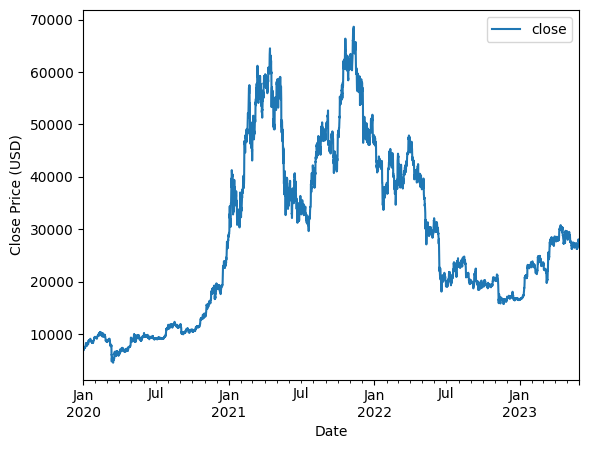

In [2]:
# Read the data from a CSV file
url = "/home/yass/code/yass2803/cryptoteller/data/BTCUSDT.csv"
df = pd.read_csv(url)
df.head()

# Change the time unit of the "open_time" column
df["open_time"] = pd.to_datetime(df["open_time"], unit='ms', origin='unix')
df = df.drop(columns=["close_time"])

df.shape

# Plot the closing price over time
ax = df.plot(x='open_time', y='close');
ax.set_xlabel("Date")
ax.set_ylabel("Close Price (USD)")

plt.show()

In [3]:
# Normalization
scaler = StandardScaler()
close_price = df.close.values.reshape(-1, 1)
scaled_close = scaler.fit_transform(close_price)

scaled_close.shape

np.isnan(scaled_close).any()

False

In [4]:
def date_to_string(date_):
    year = str(date_.year)
    month = str(date_.month)
    day = str(date_.day)

    if len(day) == 1:
        day = "0" + day

    if len(month) == 1:
        month = "0" + month

    return year + "-" + month + "-" + day

In [5]:
df_sentiment = pd.read_csv("/home/yass/code/yass2803/cryptoteller/data/sentiment/aggr_sent_btc.csv")

df_dates = df[["open_time"]].copy()
df_dates.loc[:,"date"] = df_dates.open_time.apply(lambda x: date_to_string(x))

df_sentiment = df_dates.merge(df_sentiment, on="date", how="left")
df_sentiment.drop(columns="date", inplace=True)
df_sentiment.head()


not_nan_idx = np.where(~np.isnan(df_sentiment.sentiment.values))[0]

sentiment = df_sentiment.iloc[not_nan_idx,:].sentiment.values.reshape(-1, 1)

scaled_returns_red = scaled_close[not_nan_idx]

#OHE_encoder=sklearn.preprocessing.OneHotEncoder(categories=[[0,1,2]])
#OHE_sentiment=OHE_encoder.fit_transform(sentiment).toarray()

#n_sentiment_classes = len(OHE_encoder.categories_[0])

In [6]:
df_sentiment.head()

,open_time,sentiment,neutral_count,positive_count,negative_count,weighted_avg
0,2020-01-01 00:00:00,2.0,0.0,2.0,23.0,-0.84
1,2020-01-01 06:00:00,2.0,0.0,2.0,23.0,-0.84
2,2020-01-01 12:00:00,2.0,0.0,2.0,23.0,-0.84
3,2020-01-01 18:00:00,2.0,0.0,2.0,23.0,-0.84
4,2020-01-02 00:00:00,2.0,0.0,1.0,24.0,-0.92


In [7]:
class Preprocessor:
    def __init__(self, SEQ_LEN=70):
        self.SEQ_LEN=SEQ_LEN
        pass
    def to_sequences(self, data,sentiment, seq_len):
        d = []
        s=[]

        for index in range(len(data) - seq_len):
            d.append(data[index: index + seq_len])
            s.append(sentiment[index:index+seq_len])

        return np.array(d), np.array(s)

    def preprocess(self, data_raw,sentiment, train_split):

        data, sentiment = self.to_sequences(data_raw, sentiment, self.SEQ_LEN)

        self.num_train = int(train_split * data.shape[0])

        X_train = data[:self.num_train, :-1, :]
        y_train = data[:self.num_train, -1, :]
        sentiment_train=sentiment[:self.num_train, :-1, :]

        X_test = data[self.num_train:, :-1, :]
        y_test = data[self.num_train:, -1, :]
        sentiment_test=sentiment[self.num_train:, :-1, :]

        return X_train, y_train, X_test, y_test, sentiment_train, sentiment_test

preprocessor=Preprocessor()
X_train, y_train, X_test, y_test, sentiment_train, sentiment_test = preprocessor.preprocess(scaled_returns_red,sentiment, train_split = 0.80)

print(f"sentiment train dtype: {sentiment_train.dtype}")

sentiment train dtype: float64


In [8]:
X_train=np.concatenate([X_train,sentiment_train],axis=2)

In [9]:
X_test=np.concatenate([X_test,sentiment_test],axis=2)

In [10]:
# Model

DROPOUT = 0.2
WINDOW_SIZE = preprocessor.SEQ_LEN - 1



def init_model(WINDOW_SIZE, n_sentiments, dropout, loss, optimizer, metrics):
    inputs_price = keras.Input(shape=(WINDOW_SIZE, 4))

    hidden_lstm = LSTM(10, return_sequences=True, kernel_regularizer=L1L2(l1=0.05, l2=0.05))(inputs_price)
    hidden_lstm = Dropout(rate=dropout)(hidden_lstm)

    hidden_lstm = LSTM(20, return_sequences=True, kernel_regularizer=L1L2(l1=0.05, l2=0.05))(hidden_lstm)
    hidden_lstm = Dropout(rate=dropout)(hidden_lstm)

    hidden_lstm = LSTM(30, return_sequences=False, kernel_regularizer=L1L2(l1=0.05, l2=0.05))(hidden_lstm)

    hidden_final = keras.layers.Dense(32)(hidden_lstm)
    output = Dense(1, activation="linear")(hidden_final)
    model = Model(inputs=inputs_price, outputs=output)

    print(model.summary())
    return model


In [11]:


model_seq = keras.Sequential()

model_seq.add(LSTM(WINDOW_SIZE, return_sequences=True, input_shape=(WINDOW_SIZE, X_train.shape[-1])),
                        )
model_seq.add(Dropout(rate=DROPOUT))

model_seq.add(LSTM(WINDOW_SIZE * 2, return_sequences=False))
model_seq.add(Dropout(rate=DROPOUT))

#model_seq.add(LSTM(WINDOW_SIZE, return_sequences=False))

model_seq.add(Dense(units=1))

model_seq.add(Activation('linear'))

2023-06-14 13:05:06.637089: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-06-14 13:05:06.637618: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-06-14 13:05:06.637811: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Yass): /proc/driver/nvidia/version does not exist
2023-06-14 13:05:06.640274: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
#model=init_model(WINDOW_SIZE, n_sentiment_classes, DROPOUT, 'mean_squared_error', 'adam', ["mae"])
# Training
from tensorflow import keras
from keras.callbacks import EarlyStopping
from tensorflow.keras import optimizers

es = EarlyStopping(monitor="val_loss",
                       patience=10,
                       mode="min",
                       restore_best_weights=True)


model_seq.compile(
    loss='mean_squared_error',
    metrics=["mae"] ,
    optimizer="adam"
)

BATCH_SIZE = 32

history = model_seq.fit(
    X_train,
    y_train,
    epochs=40,
    batch_size=BATCH_SIZE,
    shuffle=False,
    validation_split=0.1
)

Epoch 1/40
48/48 [==============================] - 11s 160ms/step - loss: 0.3282 - mae: 0.4110 - val_loss: 0.5773 - val_mae: 0.6909
Epoch 2/40
48/48 [==============================] - 7s 141ms/step - loss: 0.6220 - mae: 0.6299 - val_loss: 0.0614 - val_mae: 0.1528
Epoch 3/40
48/48 [==============================] - 7s 149ms/step - loss: 0.1339 - mae: 0.2935 - val_loss: 0.0589 - val_mae: 0.1234
Epoch 4/40
48/48 [==============================] - 7s 146ms/step - loss: 0.0618 - mae: 0.2028 - val_loss: 0.0695 - val_mae: 0.1882
Epoch 5/40
48/48 [==============================] - 7s 144ms/step - loss: 0.0424 - mae: 0.1668 - val_loss: 0.0509 - val_mae: 0.1099
Epoch 6/40
48/48 [==============================] - 7s 156ms/step - loss: 0.0465 - mae: 0.1732 - val_loss: 0.0487 - val_mae: 0.1077
Epoch 7/40
48/48 [==============================] - 7s 142ms/step - loss: 0.0479 - mae: 0.1749 - val_loss: 0.0459 - val_mae: 0.1018
Epoch 8/40
48/48 [==============================] - 7s 151ms/step - loss: 0

14/14 [==============================] - 1s 52ms/step - loss: 0.0059 - mae: 0.0510
MAE for the test set: 29217.996136291287


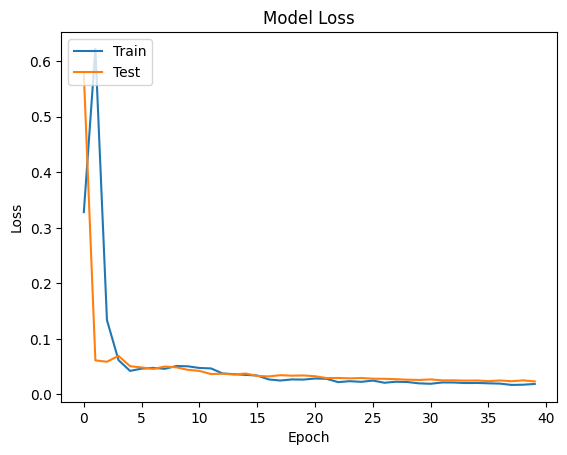

In [16]:
# Evaluation
MAE=scaler.inverse_transform([[model_seq.evaluate(X_test, y_test)[1]]])[0][0]
print(f"MAE for the test set: {MAE}")

# Plot the training loss and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [17]:
# Prediction
y_hat = model_seq.predict(X_test)
# Inverse transform the scaled data to get the actual prices
y_test_inverse = scaler.inverse_transform(y_test)
y_hat_inverse = scaler.inverse_transform(y_hat)


14/14 [==============================] - 1s 40ms/step


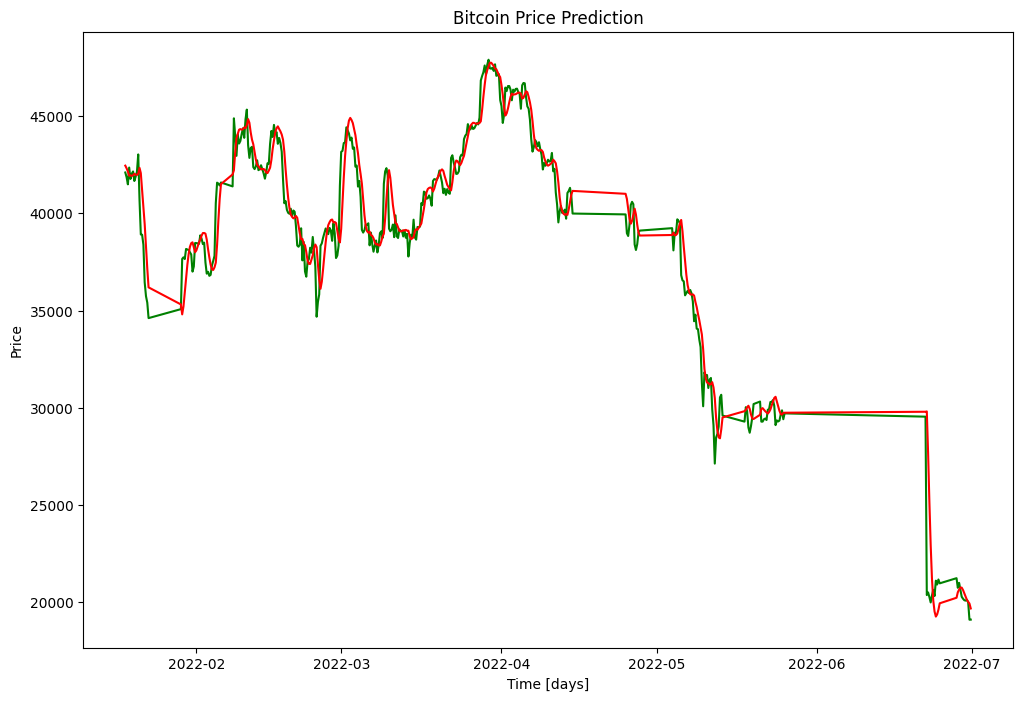

In [18]:
# Plot the actual and predicted prices
# Prediction
date_time_test = df.iloc[not_nan_idx,:].iloc[preprocessor.num_train + preprocessor.SEQ_LEN:, 0].to_numpy()

# Plot the actual and predicted prices
plt.figure(figsize=(12, 8))  # Set the figure size to make it larger
plt.plot(date_time_test, y_test_inverse, label="Actual Price", color='green')
plt.plot(date_time_test, y_hat_inverse, label="Predicted Price", color='red')

# Customize the plot
plt.title('Bitcoin Price Prediction')
plt.xlabel('Time [days]')
plt.ylabel('Price')
plt.show()